In [2]:
!pip install torchsummary

In [3]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model

%matplotlib inline

In [4]:
data_dir = "../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
diseases = os.listdir(train_dir)

In [5]:
print(diseases)

['Tomato___Early_blight', 'Apple___Black_rot', 'Tomato___healthy', 'Peach___healthy', 'Strawberry___healthy', 'Apple___healthy', 'Tomato___Late_blight', 'Corn_(maize)___healthy', 'Corn_(maize)___Common_rust_', 'Pepper,_bell___Bacterial_spot', 'Soybean___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Strawberry___Leaf_scorch', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Potato___healthy', 'Tomato___Tomato_mosaic_virus', 'Orange___Haunglongbing_(Citrus_greening)', 'Corn_(maize)___Northern_Leaf_Blight', 'Pepper,_bell___healthy', 'Tomato___Septoria_leaf_spot', 'Grape___Esca_(Black_Measles)', 'Tomato___Target_Spot', 'Tomato___Leaf_Mold', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Cherry_(including_sour)___Powdery_mildew', 'Apple___Cedar_apple_rust', 'Raspberry___healthy', 'Grape___healthy', 'Apple___Apple_scab', 'Peach___Bacterial_spot', 'Cherry_(including_sour)___healthy', 'Tomato___Bacterial_spot', 'Grape___Black_rot', 'Squash___Powdery_mildew', 'Potato___Early_blight

In [6]:
len_of_diseases = len(diseases)
print("Number of classes: {}".format(len_of_diseases))

Number of classes: 38


In [7]:
# number of images for each disease
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))

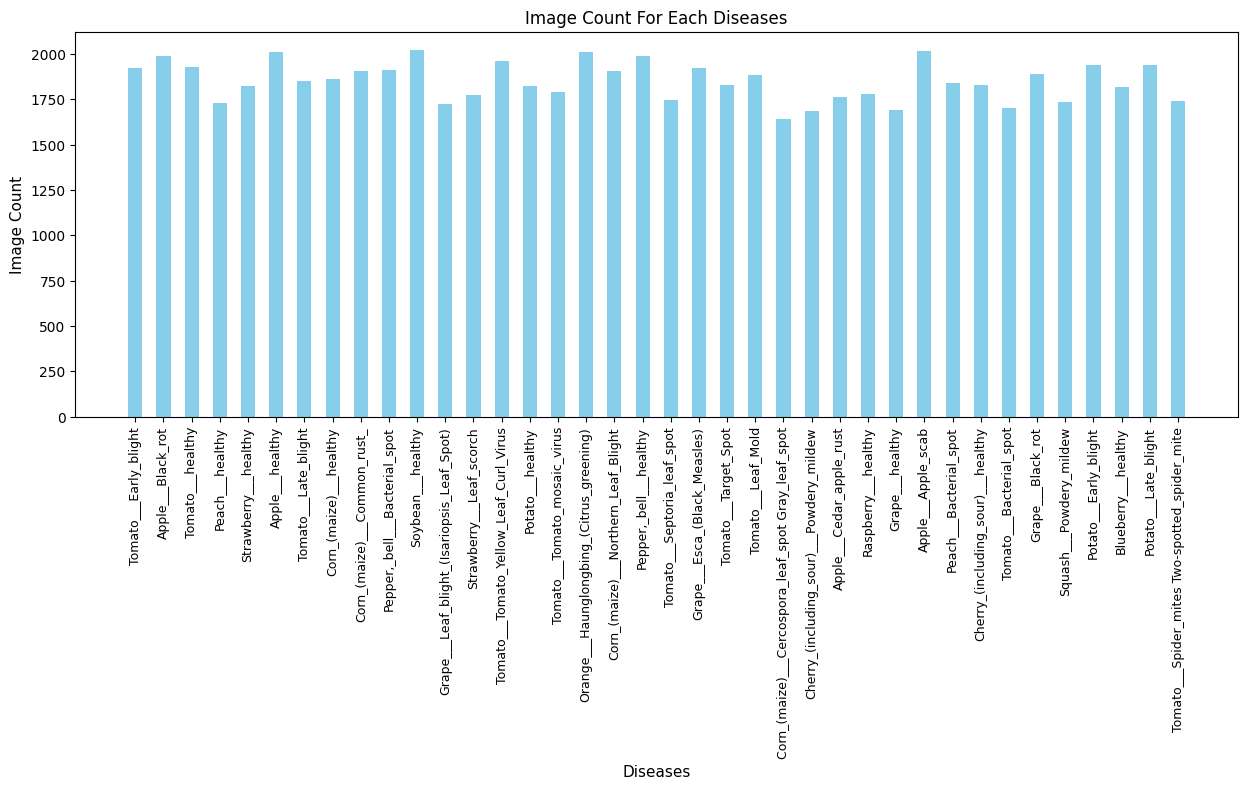

In [8]:
# plotting number of images for each disease
index = [n for n in range(len_of_diseases)]
plt.figure(figsize=(15, 5))
plt.bar(index, [count for count in nums.values()], color='skyblue', width=0.5)
plt.xlabel('Diseases', fontsize=11)
plt.ylabel('Image Count', fontsize=11)
plt.xticks(index, diseases, fontsize=9, rotation=90)
plt.title('Image Count For Each Diseases')
plt.show()

In [9]:
train = ImageFolder(train_dir, transform=transforms.ToTensor())
valid = ImageFolder(valid_dir, transform=transforms.ToTensor())

In [10]:
# shape
img, label = train[0]
print(img.shape, label)

torch.Size([3, 256, 256]) 0


In [11]:
# setting the seed value and batch size
# seed value changed
batch_size = 32
random_seed = 7
torch.manual_seed(random_seed)

In [12]:
# dataloaders for training and validation
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

In [13]:
# show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

In [14]:
# images for first batch of training
show_batch(train_dl)

Output hidden; open in https://colab.research.google.com to view.

In [15]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [16]:
device = get_default_device()
device

device(type='cuda')

In [17]:
# Moving data into GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [18]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x

In [19]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # predictions
        loss = F.cross_entropy(out, labels) # loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # prediction
        loss = F.cross_entropy(out, labels)  # loss
        acc = accuracy(out, labels)          # accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # combine loss
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # combine accuracies

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))


In [20]:
import torch.nn as nn
import torchvision.models as models

class ResNet18TransferLearning(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()

        self.resnet18 = models.resnet18(pretrained=True)

        num_ftrs = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, xb):
        return self.resnet18(xb)

In [22]:
# defining the model and moving it to the GPU
model = to_device(ResNet18TransferLearning(len_of_diseases), device)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 161MB/s]


ResNet18TransferLearning(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [23]:
# getting summary of the model
INPUT_SHAPE = (3, 256, 256)
print(summary(model.cuda(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [24]:
# for training
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # scheduler for one cycle learniing rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))


    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()


        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

    return history


In [25]:
%%time
history = [evaluate(model, valid_dl)]
history

CPU times: user 9.65 s, sys: 3.76 s, total: 13.4 s
Wall time: 16.6 s


[{'val_loss': tensor(3.8446, device='cuda:0'), 'val_accuracy': tensor(0.0284)}]

In [26]:
epochs = 5
lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam

In [27]:
%%time
history += fit_OneCycle(epochs, lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=optimizer)

Epoch [0], last_lr: 0.00076, train_loss: 0.3147, val_loss: 0.1985, val_acc: 0.9401
Epoch [1], last_lr: 0.00095, train_loss: 0.1569, val_loss: 0.1267, val_acc: 0.9571
Epoch [2], last_lr: 0.00061, train_loss: 0.0938, val_loss: 0.0939, val_acc: 0.9710
Epoch [3], last_lr: 0.00019, train_loss: 0.0349, val_loss: 0.0167, val_acc: 0.9946
Epoch [4], last_lr: 0.00000, train_loss: 0.0065, val_loss: 0.0079, val_acc: 0.9976
CPU times: user 6min 15s, sys: 4min 22s, total: 10min 38s
Wall time: 8min 29s


In [29]:
val_acc = []
val_loss = []
train_loss = []

for i in history:
    val_acc.append(i['val_accuracy'])
    val_loss.append(i['val_loss'])
    train_loss.append(i.get('train_loss'))

In [38]:
val_loss_values = [loss.item() for loss in val_loss]
val_acc_values = [acc.item() for acc in val_acc]

<ipython-input-39-73a54c6f0f3a>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(epoch_count, train_loss, 'r--', color= 'yellow')
<ipython-input-39-73a54c6f0f3a>:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epoch_count, val_loss_values, '--bo',color= 'darkblue', linewidth = '2.5', label='line with marker')


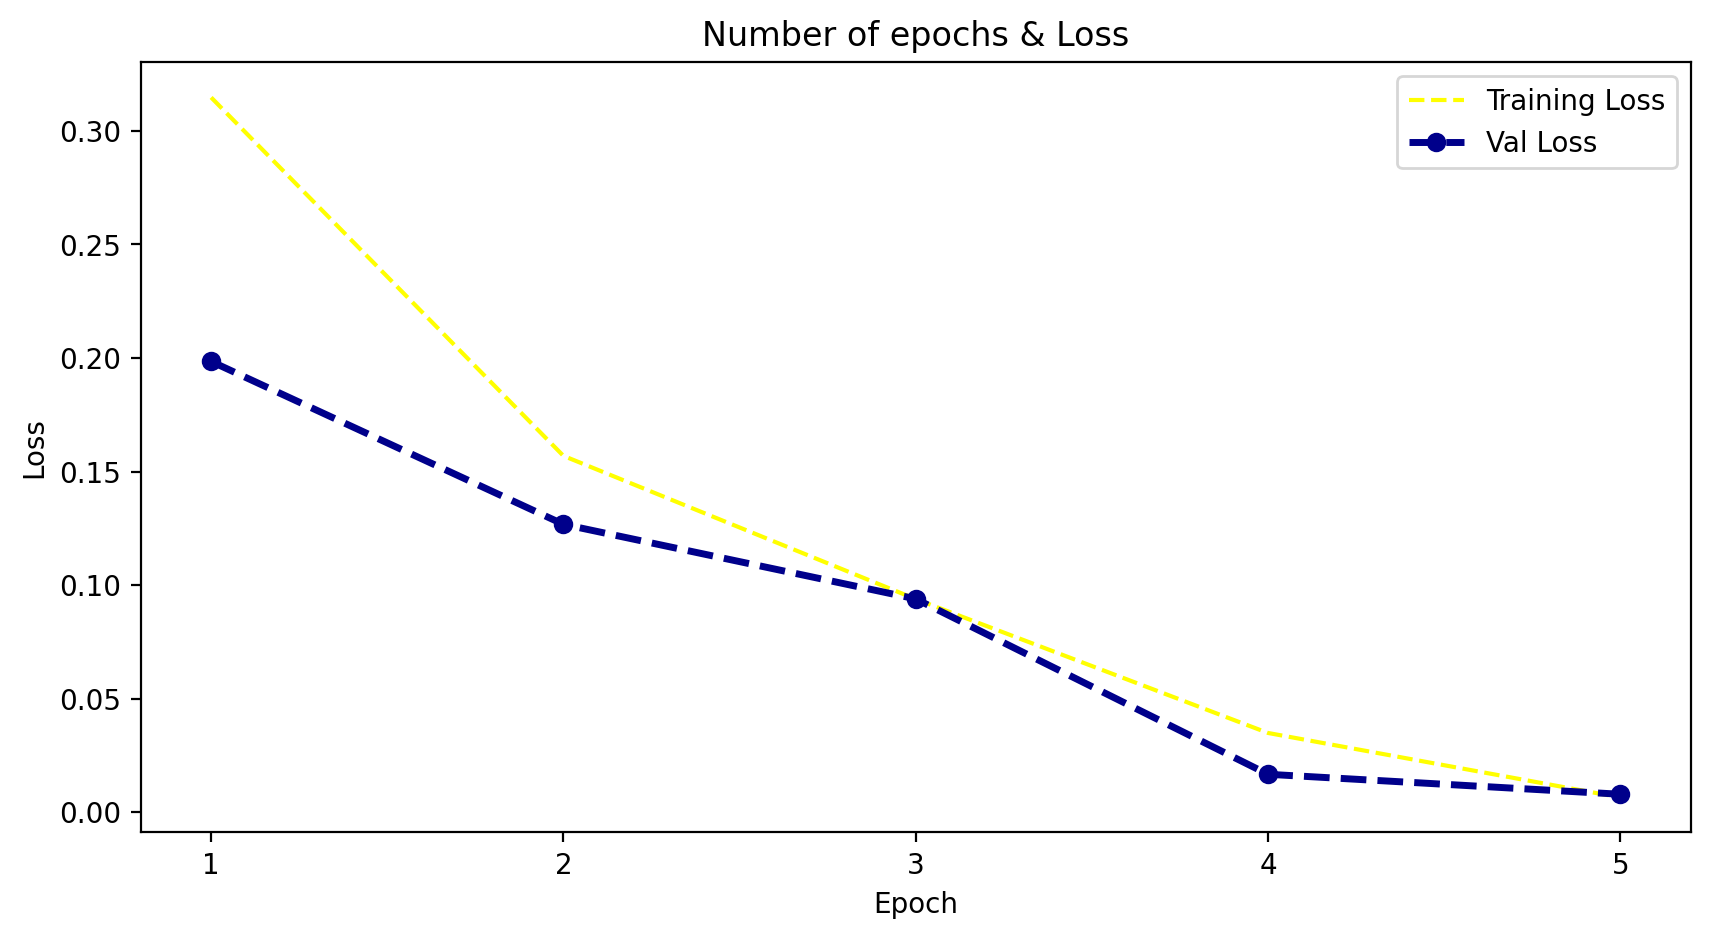

In [39]:
epoch_count = range(1,epochs + 1)
plt.figure(figsize=(10,5), dpi=200)
plt.plot(epoch_count, train_loss, 'r--', color= 'yellow')
plt.plot(epoch_count, val_loss_values, '--bo',color= 'darkblue', linewidth = '2.5', label='line with marker')
plt.legend(['Training Loss', 'Val Loss'])
plt.title('Number of epochs & Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(1,epochs + 1,1))
plt.show();

<ipython-input-40-356492e613b3>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epoch_count, val_acc_values, '--bo',color= 'skyblue', linewidth = '2.5', label='line with marker')


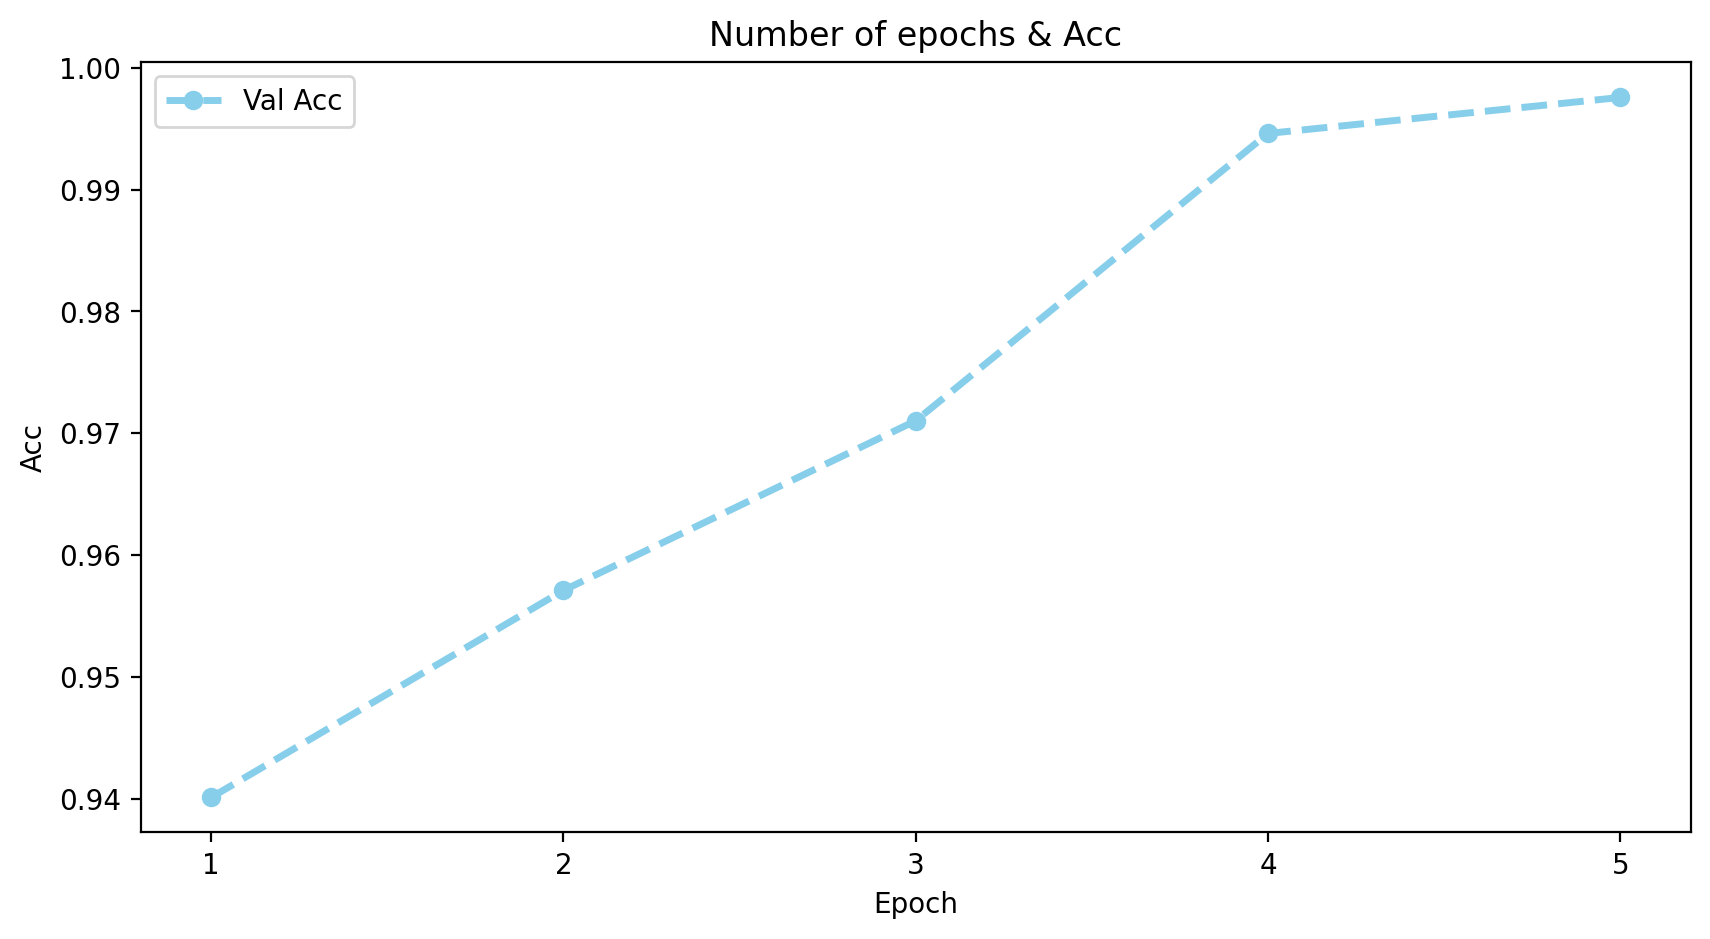

In [40]:
epoch_count = range(1,epochs + 1)
plt.figure(figsize=(10,5), dpi=200)
plt.plot(epoch_count, val_acc_values, '--bo',color= 'skyblue', linewidth = '2.5', label='line with marker')
plt.legend(['Val Acc'])
plt.title('Number of epochs & Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.xticks(np.arange(1,epochs + 1,1))
plt.show();

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [42]:
drive_path = '/content/drive/My Drive/PLANT-DISEASES-DETECTION/'

PATH = drive_path + 'resnet18TL-plant-diseaseC-model.pth'
torch.save(model.state_dict(), PATH)